# Classificação de mamíferos por imagem


O dataset [Image Classification of Mammals](https://www.kaggle.com/datasets/mannatpruthi/image-classification-of-mammals ) no Kaggle contém imagens de mamíferos de diferentes espécies. Ele inclui 13751 imagens de mamíferos, abrangendo várias categorias, como felinos, caninos, ursos, entre outros. Cada imagem é rotulada com a espécie correspondente. Existem aproximadamente 300 imagens para cada espécie, com um total de 45 espécies, iremos utilizar apenas as seguintes 10 espécies em nosso modelo:
- blue_whale
- african_elephant
- polar_bear
- kangaroo
- dolphin
- vampire_bat
- arctic_fox
- wombat
- zebra
- anteater

## Baixando o dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mannatpruthi/image-classification-of-mammals")

print("Path to dataset files:", path)
!rm -rf /content/mammals
!ls /root/.cache/kagglehub/datasets/mannatpruthi/image-classification-of-mammals/versions/1/mammals

100%|██████████| 185M/185M [00:05<00:00, 33.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mannatpruthi/image-classification-of-mammals/versions/1
african_elephant  badger      highland_cattle  mountain_goat  rhinoceros    vampire_bat    wombat
alpaca		  blue_whale  horse	       opossum	      seal	    vicuna	   yak
american_bison	  brown_bear  jackal	       orangutan      sea_lion	    walrus	   zebra
anteater	  camel       kangaroo	       otter	      snow_leopard  warthog
arctic_fox	  dolphin     koala	       polar_bear     squirrel	    water_buffalo
armadillo	  giraffe     manatee	       porcupine      sugar_glider  weasel
baboon		  groundhog   mongoose	       red_panda      tapir	    wildebeest


## Preparando o dataset
Removendo classes que não serão analisadas e separando as imagens em datasets de treino (70%) e teste (30%)

In [ ]:
%%bash

download_dir="/root/.cache/kagglehub/datasets/mannatpruthi/image-classification-of-mammals/versions/1/mammals"
if [ ! -d "$download_dir" ]; then
    exit
fi

dataset_dir="/content/mammals"
#keep_dirs=(camel horse african_elephant rhinoceros highland_cattle polar_bear brown_bear water_buffalo yak alpaca)
keep_dirs=(blue_whale african_elephant polar_bear kangaroo dolphin vampire_bat arctic_fox wombat zebra anteater)
#keep_dirs=(african_elephant  badger      highland_cattle  mountain_goat  rhinoceros    vampire_bat    wombat alpaca		  blue_whale  horse	       opossum	      seal	    vicuna	   yak american_bison	  brown_bear  jackal	       orangutan      sea_lion	    walrus	   zebra
#anteater	  camel       kangaroo	       otter	      snow_leopard  warthog arctic_fox	  dolphin     koala	       polar_bear     squirrel	    water_buffalo
#armadillo	  giraffe     manatee	       porcupine      sugar_glider  weasel baboon		  groundhog   mongoose	       red_panda      tapir	    wildebeest)
for directory in ${keep_dirs[@]}; do
    if [ ! -d "$download_dir/$directory" ]; then
        exit
    fi
done

if [ ! -d "$dataset_dir" ]; then
    dataset_dir="/content/"
    cp -r "$download_dir" "$dataset_dir"
    dataset_dir="/content/mammals"

    subdirs=$(find "$dataset_dir" -mindepth 1 -type d)
    subdirs_to_remove=$(echo "$subdirs" | grep -v -E "$(printf "%s\n" "${keep_dirs[@]}")")
    echo "$subdirs_to_remove" | xargs rm -rf
fi

if [ -d "$dataset_dir/test" ]; then
    exit
fi

split_percentage=70
seed="99999999999999999999999999999999999999999999999999999999999999999999999999
99999999999999999999999999999999999999999999999999999999999999999999999999999999
99999999999999999999999999999999999999999999999999999999999999999999999999999999
99999999999999999999999999999999999999999999999999999999999999999999999999999999
99999999999999999999999999999999999999999999999999999999999999999999999999999999"
echo $seed > /tmp/seed

mkdir -p $dataset_dir/{train,test}
for class in ${keep_dirs[@]}; do
    mkdir $dataset_dir/train/$class
    mkdir $dataset_dir/test/$class

    shuffled_files=$(ls $dataset_dir/$class | shuf --random-source /tmp/seed)

    num_files=$(ls $dataset_dir/$class | wc -l)
    num_first_split=$(($num_files * $split_percentage / 100))

    first_split=$(echo "$shuffled_files" | head -n $num_first_split)
    second_split=$(echo "$shuffled_files" | tail -n "+$((num_first_split + 1))")

    for file in $first_split; do
      mv $dataset_dir/$class/$file $dataset_dir/train/$class/
    done

    for file in $second_split; do
      mv $dataset_dir/$class/$file $dataset_dir/test/$class/
    done
    rmdir $dataset_dir/$class
done

## Imports

In [ ]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn import metrics

#To ensure reproducibility
#we set the random seed
seed_number = 10
tf.random.set_seed(seed_number)
np.random.seed(seed_number)

## Funções de plot

In [ ]:
#Auxiliary Function to plot images side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

#Plot dataset samples
def plot_dataset(ds, lbls_name):
  N_SAMPLES = 10
  for i in range(5):
    for x,y in ds.take(1):

      x = x.numpy()
      x = np.squeeze(x)
      y = y.numpy()
      plot_sidebsyide(x[:N_SAMPLES],
                      y[:N_SAMPLES],'gray')

#Plot a training history
def plot_history(history):
  #print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

## Carregando os dados

In [ ]:
data_dir = '/content/mammals/train'
batch_size_ = 32
input_shape_ = (256,256,3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

Found 2105 files belonging to 10 classes.
Using 1684 files for training.
Found 2105 files belonging to 10 classes.
Using 421 files for validation.


## Visualização dos dados

['african_elephant', 'anteater', 'arctic_fox', 'blue_whale', 'dolphin', 'kangaroo', 'polar_bear', 'vampire_bat', 'wombat', 'zebra']


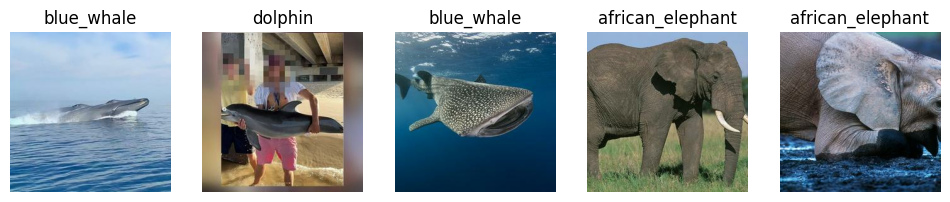

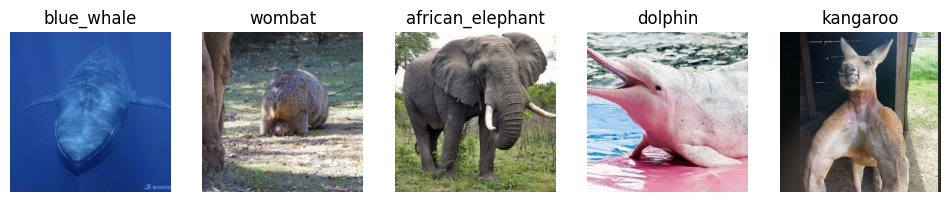

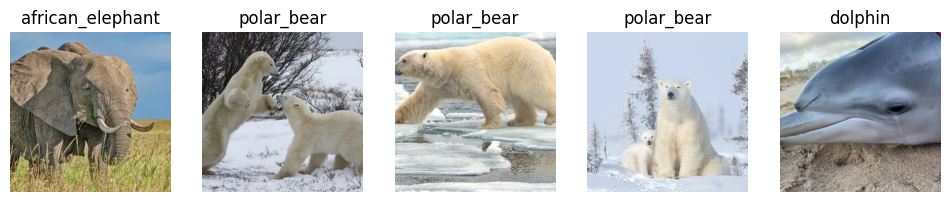

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
class_names = np.array(class_names)
for img,lbl in train_ds.take(7):

  titles = []
  #print(lbl)
  for i in lbl:
    titles.append(class_names[i])

  plot_sidebyside(img[:7]/255.,titles[:7])


## Definição da Rede Neural Convolucional
Definimos uma rede neural convolucional com 7 camadas convolucionais para a extração de *features* das imagens

In [ ]:
model = models.Sequential()

#Feature Learning (Convolutions)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(32, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
######################################

#Fully-Connect (Classifcation)
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
#model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))



model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_75 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_77 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_78 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_79 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_78 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_80 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_79 (Conv2D)                   │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_81 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_80 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_82 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_83 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 561,418 (2.14 MB)

 Trainable params: 561,418 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

## Treinando o modelo

In [ ]:
epochs_ = 30
#lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#    monitor='val_loss',
#    factor=0.3,
#    patience=5,
#    min_lr=0.01
#)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(

    filepath='/content/my_model/model_checkpoint.weights.h5',  # Specify the file to save the weights
    save_best_only=True,             # Save only the best model
    save_weights_only=True,
    monitor='val_acc' ,              # Monitoring validation loss
    mode='max',
    verbose=1
)
model.compile(optimizer=optimizers.Adam(0.0001), loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds, callbacks=[checkpoint_callback])

Epoch 1/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - acc: 0.0290 - loss: 5.6140
Epoch 1: val_acc improved from -inf to 0.03175, saving model to /content/my_model/model_checkpoint.weights.h5
241/241 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - acc: 0.0290 - loss: 5.6083 - val_acc: 0.0318 - val_loss: 3.7670
Epoch 2/30
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 0.0432 - loss: 3.7757
Epoch 2: val_acc improved from 0.03175 to 0.05414, saving model to /content/my_model/model_checkpoint.weights.h5
241/241 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - acc: 0.0432 - loss: 3.7755 - val_acc: 0.0541 - val_loss: 3.7154
Epoch 3/30
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.0477 - loss: 3.7049
Epoch 3: val_acc improved from 0.05414 to 0.07548, saving model to /content/my_model/model_checkpoint.weights.h5
241/241 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - acc: 0.0478 - loss: 3.7046 - val_acc: 0.0755 - val_loss: 3.6391
Epoch 4/30
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 0.0806 - loss: 3.6107
Epoch 4:

## Mostrando o histórico do treinamento

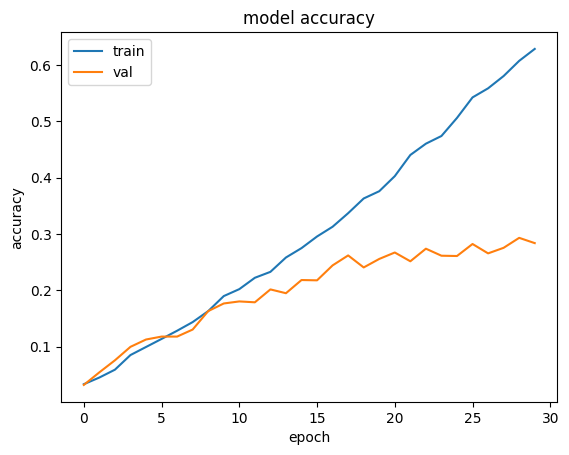

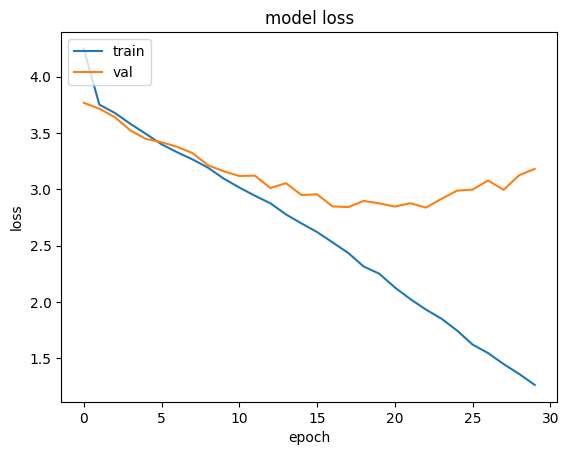

In [ ]:
plot_history(history)

## Transfer Learning

In [ ]:
# From resnet
conv_layers = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,
                                                      input_tensor=tf.keras.layers.Input(input_shape_),
                                                      classes=num_classes)
conv_layers.trainable = False


conv_layers.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

## Utilizando apenas a parte convolucional do modelo Resnet50

In [ ]:
model = tf.keras.Sequential([
  layers.Input(shape=input_shape_),
  conv_layers,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),

  layers.Flatten(),

  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/my_model/model_checkpoint.weights.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_acc' ,
    mode='max',
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,146,442 (92.11 MB)

 Trainable params: 558,730 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Fine Tuning das últimas 3 camadas de convolução

In [ ]:
conv_layers.trainable=True

n_layers = len(conv_layers.layers)
print(n_layers)

for j in range(0,n_layers-10):
    conv_layers.layers[j].trainable = False


for j in range(n_layers-10,n_layers):
    conv_layers.layers[j].trainable = True

conv_layers.summary()

175


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 4,465,664 (17.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

## Redefinindo a rede

In [ ]:
model = tf.keras.Sequential([
  layers.Input(shape=input_shape_),

  conv_layers,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),

  layers.Flatten(),
  #layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/my_model/model_checkpoint.weights.h5',  # Specify the file to save the weights
    save_best_only=True,             # Save only the best model
    save_weights_only=True,
    monitor='val_acc' ,              # Monitoring validation loss
    mode='max',
    verbose=1
)

epochs_ = 70
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds, callbacks=[checkpoint_callback])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,146,442 (92.11 MB)

 Trainable params: 5,024,394 (19.17 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

Epoch 1/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - acc: 0.7479 - loss: 0.8113
Epoch 1: val_acc improved from -inf to 0.76485, saving model to /content/my_model/model_checkpoint.weights.h5
53/53 ━━━━━━━━━━━━━━━━━━━━ 51s 565ms/step - acc: 0.7500 - loss: 0.8046 - val_acc: 0.7648 - val_loss: 3.6452
Epoch 2/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - acc: 0.9571 - loss: 0.1280
Epoch 2: val_acc improved from 0.76485 to 0.90736, saving model to /content/my_model/model_checkpoint.weights.h5
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - acc: 0.9572 - loss: 0.1280 - val_acc: 0.9074 - val_loss: 0.7074
Epoch 3/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - acc: 0.9855 - loss: 0.0574
Epoch 3: val_acc did not improve from 0.90736
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - acc: 0.9854 - loss: 0.0575 - val_acc: 0.8551 - val_loss: 1.2670
Epoch 4/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - acc: 0.9863 - loss: 0.0440
Epoch 4: val_acc improved from 0.90736 to 0.93349, saving model to /content/my_model/

## Avaliando

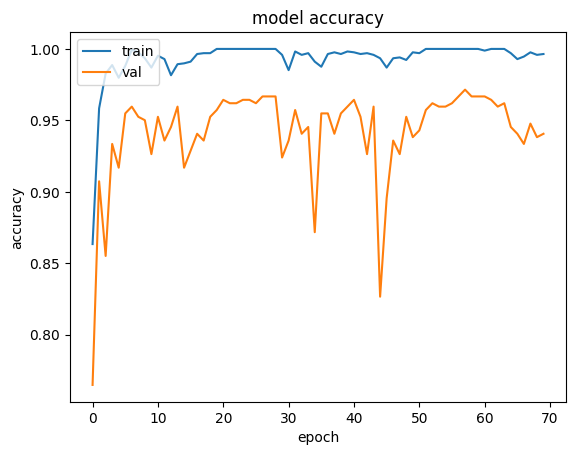

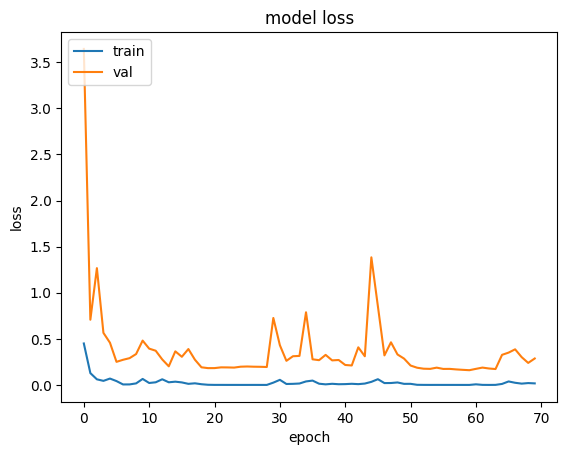

In [ ]:
plot_history(history)

## Carregando dados de teste

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  f'/content/mammals/test/',
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

model.evaluate(test_ds)

Found 909 files belonging to 10 classes.
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - acc: 0.9442 - loss: 0.2289


[0.20929555594921112, 0.9482948184013367]

## Lendo uma imagem e testando com a rede

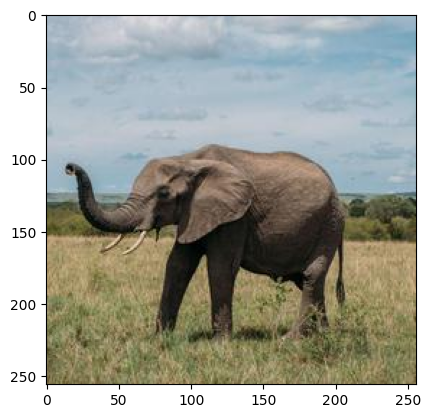

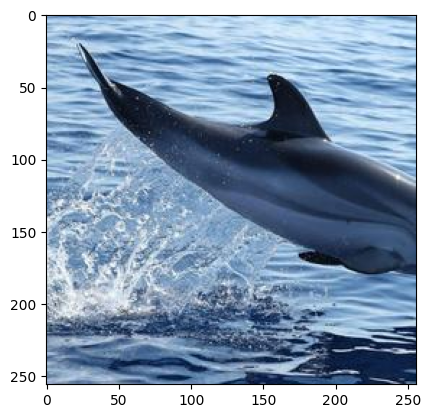

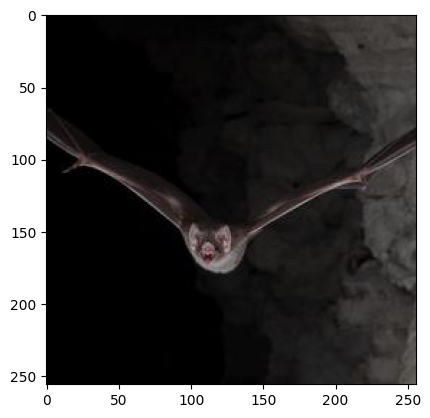

['african_elephant' 'anteater' 'arctic_fox' 'blue_whale' 'dolphin'
 'kangaroo' 'polar_bear' 'vampire_bat' 'wombat' 'zebra']
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
african_elephant
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
dolphin
[0.00000023 0.00000002 0.         0.0000015  0.00000028 0.00000004
 0.         0.999998   0.00000001 0.        ]
vampire_bat


In [ ]:
np.set_printoptions(suppress=True) #evita notacao cientifica
import cv2 #opencv library

imlist = []

img = cv2.imread('/content/mammals/test/african_elephant/african_elephant-0006.jpg')
img = cv2.resize(img,(input_shape_[0],input_shape_[1]))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
imlist.append(img)


img = cv2.imread('/content/mammals/test/dolphin/dolphin-0020.jpg')
img = cv2.resize(img,(input_shape_[0],input_shape_[1]))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
imlist.append(img)


img = cv2.imread('/content/mammals/test/vampire_bat/vampire_bat-0007.jpg')
img = cv2.resize(img,(input_shape_[0],input_shape_[1]))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
imlist.append(img)

print(class_names)
res = model.predict(np.array(imlist))
#print(res)

for r in res:
  print(r)
  class_id = np.argmax(r)
  #print(class_id)
  print(class_names[class_id])

## Analisando quantitativamente

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

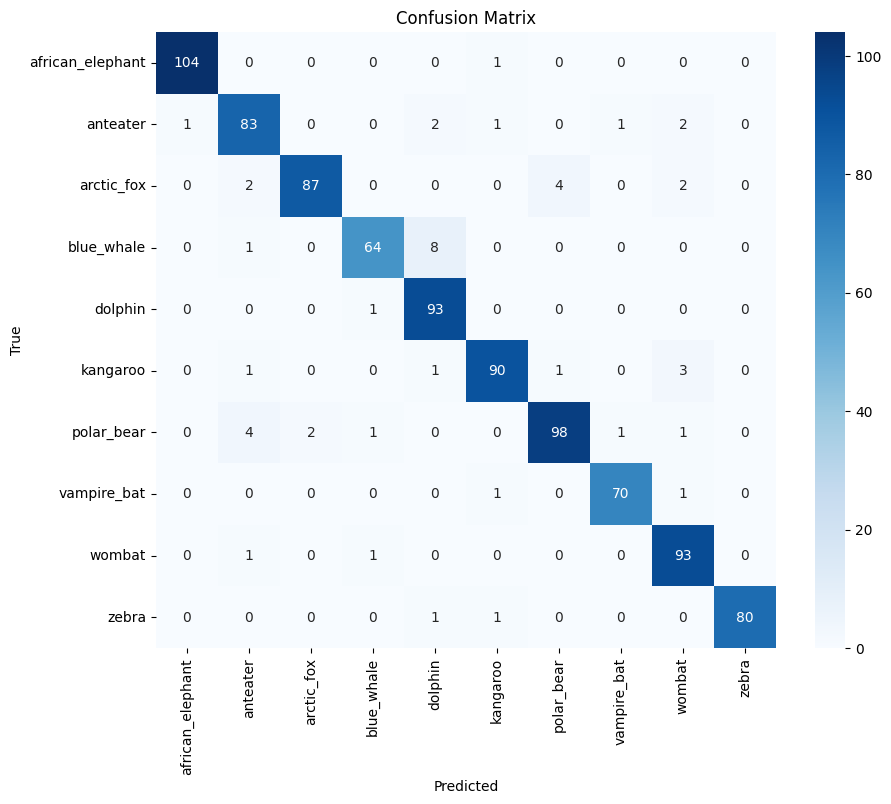

                  precision    recall  f1-score   support

african_elephant       0.99      0.99      0.99       105
        anteater       0.90      0.92      0.91        90
      arctic_fox       0.98      0.92      0.95        95
      blue_whale       0.96      0.88      0.91        73
         dolphin       0.89      0.99      0.93        94
        kangaroo       0.96      0.94      0.95        96
      polar_bear       0.95      0.92      0.93       107
     vampire_bat       0.97      0.97      0.97        72
          wombat       0.91      0.98      0.94        95
           zebra       1.00      0.98      0.99        82

        accuracy                           0.95       909
       macro avg       0.95      0.95      0.95       909
    weighted avg       0.95      0.95      0.95       909

tf.Tensor([2 4 2 2 1 3 8 1 8 6 8 9 1 6 3 2 4 3 6 1 0 0 1 7 1 6 9 7 4 2 0 1], shape=(32,), dtype=int32)
(32, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


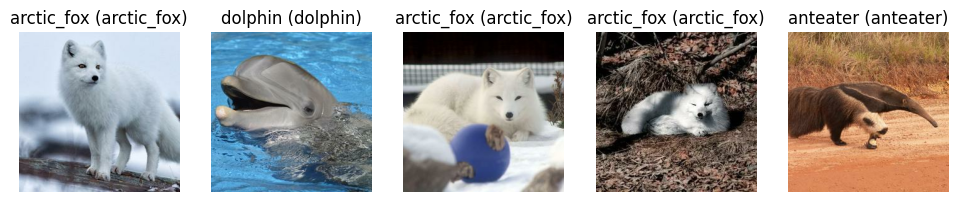

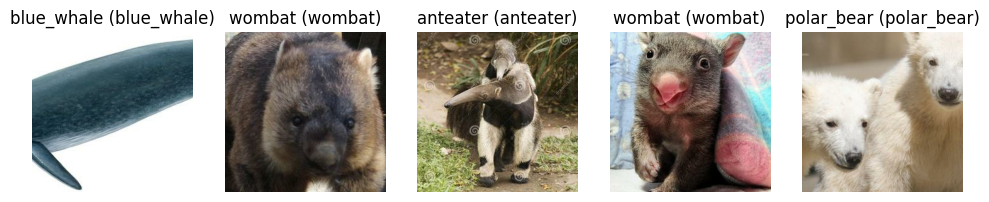

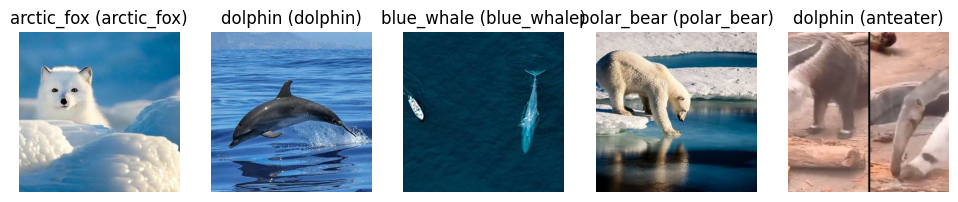

In [ ]:
#Predição (predict) de todo o dataset e analisando quantitivamente
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

for images, labels in test_ds:
  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions, axis=1)
  y_true.extend(labels.numpy())
  y_pred.extend(predicted_labels)

cm = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


# Analise qualitativa (visualmente, interpetera erros e acerto)
import numpy as np
for img, lbl in test_ds.take(1):
  print(lbl)
  print(img.shape)
  prediction = model.predict(img)
  #print(prediction)
  predicted_labels = np.argmax(prediction, axis=1)
  titles = []
  for true,pred in zip(lbl,predicted_labels):
    titles.append(f'{class_names[pred]} ({class_names[true]})')

  plot_sidebyside(img[:5] / 255., titles[:5])
  plot_sidebyside(img[5:10] / 255., titles[5:10])
  plot_sidebyside(img[15:20] / 255., titles[15:20])